In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import time as pctime

# load national data

In [16]:
# dati cumulativi

data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
xdata=pd.to_numeric(range(data.shape[0]))
ydata=data['totale_casi']
ydata_death=data['deceduti']
ydata_rec=data['dimessi_guariti']

ydata_inf=ydata-ydata_rec-ydata_death

print(data.iloc[-1,:])

data.head()

data                          2020-05-11T17:00:00
stato                                         ITA
ricoverati_con_sintomi                      13539
terapia_intensiva                             999
totale_ospedalizzati                        14538
isolamento_domiciliare                      67950
totale_positivi                             82488
variazione_totale_positivi                   -836
nuovi_positivi                                744
dimessi_guariti                            106587
deceduti                                    30739
totale_casi                                219814
tamponi                                   2606652
casi_testati                          1.70228e+06
note_it                                       NaN
note_en                                       NaN
Name: 77, dtype: object


,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN,NaN


In [17]:
# dati differenziali

ydata_incr=[]
ydata_death_incr=[]
ydata_rec_incr=[]

for i in range(len(ydata)-1):
    ydata_incr.append(ydata[i+1]-ydata[i])
    ydata_death_incr.append(ydata_death[i+1]-ydata_death[i])
    ydata_rec_incr.append(ydata_rec[i+1]-ydata_rec[i])

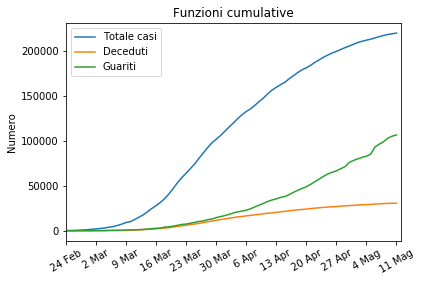

In [18]:
plt.plot(np.arange(len(ydata)),ydata,label='Totale casi')
plt.plot(np.arange(len(ydata)),ydata_death,label='Deceduti')
plt.plot(np.arange(len(ydata)),ydata_rec,label='Guariti')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
plt.ylabel('Numero')
plt.title('Funzioni cumulative')
plt.legend()
plt.savefig('dataonly_cumulative.png')
plt.show()

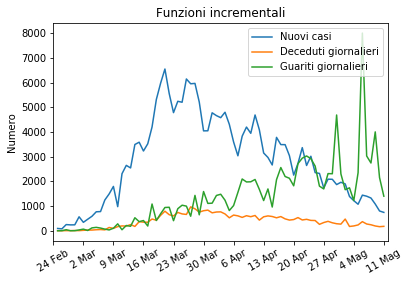

In [19]:
plt.plot(np.arange(len(ydata_incr)),ydata_incr,label='Nuovi casi')
plt.plot(np.arange(len(ydata_incr)),ydata_death_incr,label='Deceduti giornalieri')
plt.plot(np.arange(len(ydata_incr)),ydata_rec_incr,label='Guariti giornalieri')
plt.xticks(np.arange(-1,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(-1,len(ydata_incr))
plt.ylabel('Numero')
plt.title('Funzioni incrementali')
plt.legend()
plt.savefig('dataonly_deriv.png')
plt.show()

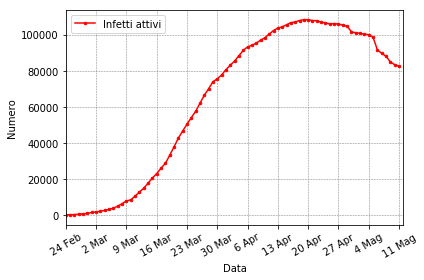

In [20]:
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',marker='.',markersize=5,label='Infetti attivi')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
#plt.ylim(0,120000)
plt.xlabel('Data')
plt.ylabel('Numero')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('infetti_attivi.png',dpi=300)
plt.show()

# definition of the models

### definition of SIR 1.0

In [21]:
# The SIR model differential equations.
def deriv_SIR(y, t, N, beta,gamma):
    S,I,R = y

    dSdt = -(beta*I/N)*S 
    dIdt = (beta*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt

def SIR(N,beta,gamma,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR, y0, t, args=(N,beta,gamma))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

### definition of SIR 2.0 

In [22]:
# The SIR model differential equations.
def deriv_SIR_2(y, t, N, beta1,gamma,tau=10**6,t_thresh=14):
    S,I,R = y
    
    if t<=t_thresh:      # il lockdown nazionale inizia al 14° giorno 
        B=beta1
    else: 
        B=beta1*np.exp(-(t-t_thresh)/tau)

    dSdt = -(B*I/N)*S 
    dIdt = (B*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt


def SIR_2(N,beta1,gamma,tau=10**6,t_thresh=14,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR_2, y0, t, args=(N,beta1,gamma,tau,t_thresh))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

# fitting the active infected

In [23]:
# 3 parameter fit for the active infected

def optimizer_adv(R0,tau,t_thresh):
    fin_result_updated=SIR_2(6*10**7,R0*1/14,1/14,tau,t_thresh,I0=3*ydata_inf[0])
    i_vec=fin_result_updated[2]/3
    
    pesi=np.exp(-np.arange(len(ydata_inf))/7)    # 
    pesi=pesi[::-1]
    
    accuracy=np.sum((ydata_inf-i_vec[0:len(ydata_inf)])**2/ydata_inf**2*pesi)   #mean squared error. This is used for the optimization
    
    errperc=np.mean(np.abs((ydata_inf-i_vec[0:len(ydata_inf)])/ydata_inf))*100
    stdperc=np.std(np.abs((ydata_inf-i_vec[0:len(ydata_inf)])/ydata_inf))*100
    
    return accuracy,errperc,stdperc

In [24]:
# grid on 3 parameters
R0grid=np.linspace(4.5,6,20)
taugrid=np.linspace(29,33,20)
ttreshgrid=np.arange(0,11,1)

res_scan=[]
counter=0
counter2=0
cycle_tot=len(R0grid)*len(taugrid)*len(ttreshgrid)

time1=pctime.time()

# minimization

for r in R0grid:
    for tau in taugrid:
        for tt in ttreshgrid:
            opt_res=optimizer_adv(r,tau,tt)
            res_scan.append([r,tau,tt,opt_res[0],opt_res[1],opt_res[2]])
            counter=counter+1
            counter2=counter2+1
            if counter2==cycle_tot/10:
                time2=pctime.time()
                remtime=round((time2-time1)/counter*(cycle_tot-counter),1)
                print('completed ',round(counter/cycle_tot*100,1),'%. Remaining time ',remtime,'sec')
                counter2=0
        
res_scan=np.array(res_scan)

completed  10.0 %. Remaining time  25.6 sec
completed  20.0 %. Remaining time  23.6 sec
completed  30.0 %. Remaining time  20.6 sec
completed  40.0 %. Remaining time  17.4 sec
completed  50.0 %. Remaining time  14.6 sec
completed  60.0 %. Remaining time  11.7 sec
completed  70.0 %. Remaining time  8.8 sec
completed  80.0 %. Remaining time  5.9 sec
completed  90.0 %. Remaining time  2.9 sec
completed  100.0 %. Remaining time  0.0 sec


In [25]:
df_res_scan=pd.DataFrame(res_scan)
df_res_scan.columns=['R0','tau','t_thresh','MSE','mean err%','std err%']

df_res_scan.sort_values(by='MSE')

,R0,tau,t_thresh,MSE,mean err%,std err%
654,4.657895,33.000000,5.0,0.016388,12.164828,8.796232
2190,5.210526,33.000000,1.0,0.016567,10.257705,6.068545
413,4.578947,32.578947,6.0,0.016611,12.493899,8.618327
2629,5.368421,33.000000,0.0,0.016737,10.174087,5.980032
1751,5.052632,33.000000,2.0,0.017585,10.372401,6.653706
172,4.500000,32.157895,7.0,0.018708,13.019860,8.757586
1082,4.815789,32.789474,4.0,0.018780,11.446703,6.829916
830,4.736842,32.157895,5.0,0.021305,11.318348,6.605655
1071,4.815789,32.578947,4.0,0.022691,10.855619,6.992307
424,4.578947,32.789474,6.0,0.022952,13.309103,8.180197


In [26]:
par_ideal=np.array(df_res_scan.sort_values(by='MSE').iloc[0,0:])

par_ideal[0:3]

array([ 4.65789474, 33.        ,  5.        ])

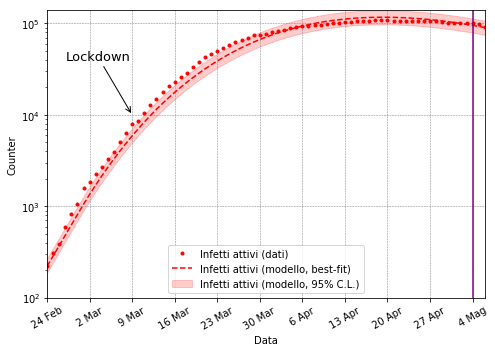

In [27]:
fin_result_updated=SIR_2(6*10**7,par_ideal[0]*1/14,1/14,par_ideal[1],t_thresh=par_ideal[2],I0=3*ydata_inf[0])

t=fin_result_updated[0]
s_vec=fin_result_updated[1]
i_vec=fin_result_updated[2]
r_vec=fin_result_updated[3]

plt.figure(figsize=(7,5))
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti attivi (dati)')
plt.plot(t, i_vec/3, label='Infetti attivi (modello, best-fit)',color='red',linestyle='--')
plt.fill_between(t, i_vec*(1+par_ideal[5]/100*2)/3,i_vec*(1-par_ideal[5]/100*2)/3, label='Infetti attivi (modello, 95% C.L.)',color='red',alpha=.2)
plt.plot(np.zeros(2)+70,[-1000,250000],color='purple')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,72)
plt.ylim(100,ydata_inf.max()*1.3)
plt.yscale('log')
plt.annotate("Lockdown", xy=(14,10000), xytext=(3,40000), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('fit_con_incertezza.png',dpi=300)
plt.show()  

In [28]:
i_vec[70]*(1+par_ideal[5]/100*5)/3,i_vec[70]*(1-par_ideal[5]/100*5)/3

(137217.33738635495, 53387.23635266611)

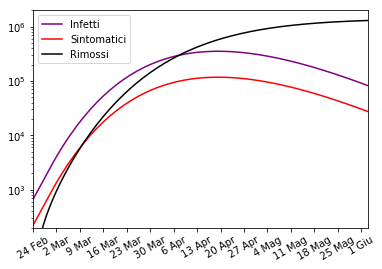

In [29]:
plt.plot(t,s_vec)
plt.plot(t,i_vec,label='Infetti',color='purple')
plt.plot(t,i_vec/3,label='Sintomatici',color='red')
plt.plot(t,r_vec,label='Rimossi',color='black')
plt.yscale('log')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,100)
plt.ylim(200,2*10**6)
plt.legend()
plt.show()

In [30]:
#export

t_date=pd.to_datetime(t,unit='D',origin=pd.Timestamp('2020-02-24'))

export_v2 = pd.DataFrame({'date':t_date,'t':t,'s':s_vec,'i':i_vec,'r':r_vec})
export_v2.to_csv('output/nazionale.csv',index=False)

In [31]:
export_v2

,date,t,s,i,r
0,2020-02-24,0,5.999934e+07,663.000000,0.000000e+00
1,2020-02-25,1,5.999908e+07,860.960685,5.411965e+01
2,2020-02-26,2,5.999876e+07,1118.027326,1.243985e+02
3,2020-02-27,3,5.999833e+07,1451.846216,2.156611e+02
4,2020-02-28,4,5.999778e+07,1885.331151,3.341727e+02
5,2020-02-29,5,5.999706e+07,2448.235258,4.880686e+02
6,2020-03-01,6,5.999615e+07,3163.366320,6.875582e+02
7,2020-03-02,7,5.999501e+07,4047.580623,9.440017e+02
8,2020-03-03,8,5.999360e+07,5130.002774,1.270501e+03
9,2020-03-04,9,5.999188e+07,6442.260886,1.682330e+03


# computation of national R0

### using data of last 5 days

r0  0.67


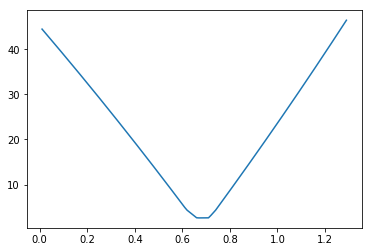

In [32]:
today=len(xdata)

def minimizer(R0,t1=today-5,t2=today):
    
    #true data
    ydata_inf_2=np.array(ydata_inf[t1:t2])
    xdata_2=np.arange(0,len(ydata_inf_2))
    
    #print(ydata_inf_2)
    
    #model
    fin_result=SIR(60*10**6,1/14*R0,1/14,I0=ydata_inf_2[0])
    i_vec=fin_result[2]
    i_vec_2=i_vec[0:len(xdata_2)]
    
    #average error
    error=np.sum(np.abs(ydata_inf_2-i_vec_2)/ydata_inf_2)*100
    
    return error

minimizer_vec=np.vectorize(minimizer)


#definition of the ideal r0

xgrid=np.arange(0.01,1.3,0.01)
ygrid=minimizer_vec(xgrid)
r0_ideal=round(xgrid[np.argmin(ygrid)],2)
print('r0 ',r0_ideal)

plt.plot(xgrid,ygrid)
plt.show()

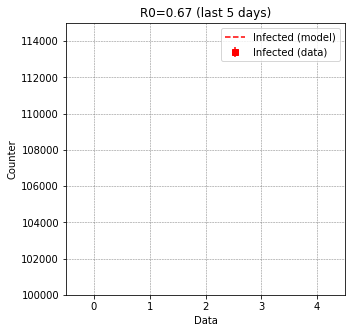

In [33]:
ydata_inf_2=np.array(ydata_inf[today-5:today])
xdata_2=np.arange(0,len(ydata_inf_2))

fin_result=SIR(60*10**6,1/14*r0_ideal,1/14,I0=ydata_inf_2[0])

t_R0=fin_result[0]
#s_vec=fin_result[1]
i_vec_R0=fin_result[2]
#r_vec=fin_result[3]

plt.figure(figsize=(5,5))
plt.errorbar(xdata_2,ydata_inf_2,np.sqrt(ydata_inf_2),color='red',linestyle='None',marker='s',label='Infected (data)')
plt.plot(t_R0, i_vec_R0, 'r--', label='Infected (model)')
#plt.yscale('log')
#plt.xticks(np.arange(14,70,7),['21 Feb','28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr'],rotation=30)
plt.xlim(-0.5,4.5)
plt.ylim(10**5,1.15*10**5)
#plt.ylim(0,300)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('R0='+str(r0_ideal)+' (last 5 days)')
plt.savefig('r0-5days.png',dpi=300)
plt.show()

### scan of R0 over time

In [34]:
time_window=5

def minimizer_gen(t1,t2,xgrid=np.arange(0.1,5,0.01)):

    ygrid=minimizer_vec(xgrid,t1=t1,t2=t2)
    r0_ideal=round(xgrid[np.argmin(ygrid)],2)

    return r0_ideal

r0_time=[]
scangrid=np.linspace(0,5,100)

for i in range(0,today-(time_window-1)):
    min_val=minimizer_gen(i,i+time_window,xgrid=scangrid)
    r0_time.append(min_val)
    scangrid=np.linspace(min_val/2,min_val*2,100)  #the grid change over the time (this speed up the process)
    print('Day n',i,' R0=',min_val)
    print(i,i+time_window,len(ydata_inf))
    
r0_time=np.array(r0_time)

Day n 0  R0= 5.0
0 5 78
Day n 1  R0= 5.3
1 6 78
Day n 2  R0= 5.94
2 7 78
Day n 3  R0= 5.04
3 8 78
Day n 4  R0= 4.58
4 9 78
Day n 5  R0= 4.58
5 10 78
Day n 6  R0= 3.54
6 11 78
Day n 7  R0= 3.7
7 12 78
Day n 8  R0= 3.64
8 13 78
Day n 9  R0= 3.92
9 14 78
Day n 10  R0= 4.1
10 15 78
Day n 11  R0= 4.29
11 16 78
Day n 12  R0= 3.58
12 17 78
Day n 13  R0= 3.36
13 18 78
Day n 14  R0= 3.21
14 19 78
Day n 15  R0= 3.6
15 20 78
Day n 16  R0= 3.38
16 21 78
Day n 17  R0= 3.18
17 22 78
Day n 18  R0= 3.04
18 23 78
Day n 19  R0= 2.76
19 24 78
Day n 20  R0= 2.63
20 25 78
Day n 21  R0= 2.71
21 26 78
Day n 22  R0= 2.71
22 27 78
Day n 23  R0= 2.83
23 28 78
Day n 24  R0= 2.57
24 29 78
Day n 25  R0= 2.34
25 30 78
Day n 26  R0= 2.09
26 31 78
Day n 27  R0= 1.99
27 32 78
Day n 28  R0= 1.96
28 33 78
Day n 29  R0= 1.93
29 34 78
Day n 30  R0= 1.93
30 35 78
Day n 31  R0= 1.81
31 36 78
Day n 32  R0= 1.59
32 37 78
Day n 33  R0= 1.49
33 38 78
Day n 34  R0= 1.4
34 39 78
Day n 35  R0= 1.44
35 40 78
Day n 36  R0= 1.46
36 4

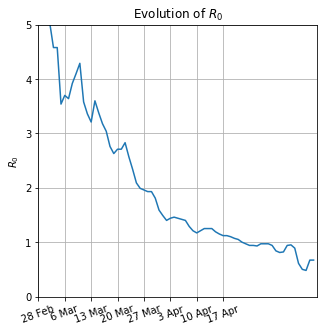

In [35]:
plt.figure(figsize=(5,5))
plt.plot(r0_time)
plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
plt.xlim(0,today-4)
#plt.xlim(19,today-9)
plt.ylabel('$R_0$')
plt.ylim(0,5)
plt.grid()
plt.title('Evolution of $R_0$')
#plt.savefig('output3/r0-evo.png',dpi=300)
plt.show()

In [36]:
# export R0 over time

df_r0=pd.DataFrame(pd.to_datetime(np.arange(len(r0_time)),unit='D',origin='2020-02-28'))
df_r0['R0']=r0_time
df_r0.columns=['Data','R0']

df_r0.to_csv('output/r0.csv',index=False)

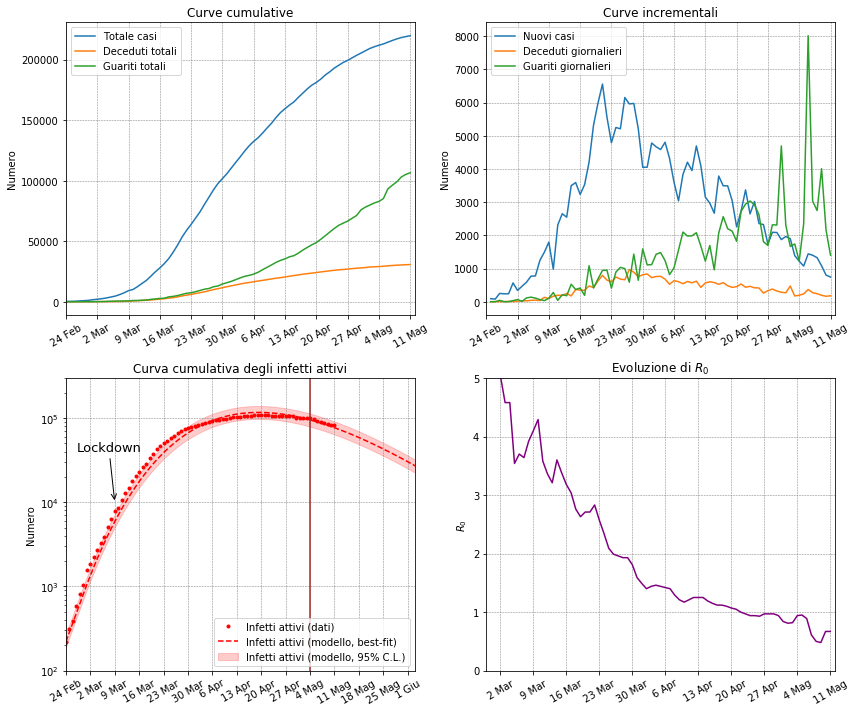

In [37]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(np.arange(len(ydata)),ydata,label='Totale casi')
plt.plot(np.arange(len(ydata)),ydata_death,label='Deceduti totali')
plt.plot(np.arange(len(ydata)),ydata_rec,label='Guariti totali')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
plt.ylabel('Numero')
plt.title('Curve cumulative')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.subplot(2,2,2)
plt.plot(np.arange(len(ydata_incr)),ydata_incr,label='Nuovi casi')
plt.plot(np.arange(len(ydata_incr)),ydata_death_incr,label='Deceduti giornalieri')
plt.plot(np.arange(len(ydata_incr)),ydata_rec_incr,label='Guariti giornalieri')
plt.xticks(np.arange(-1,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(-1,len(ydata_incr))
plt.ylabel('Numero')
plt.title('Curve incrementali')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.subplot(2,2,3)
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti attivi (dati)')
plt.plot(t, i_vec/3, label='Infetti attivi (modello, best-fit)',color='red',linestyle='--')
plt.fill_between(t, i_vec*(1+par_ideal[5]/100*2)/3,i_vec*(1-par_ideal[5]/100*2)/3, label='Infetti attivi (modello, 95% C.L.)',color='red',alpha=.2)
plt.plot(np.zeros(2)+70,[-1000,500000],color='brown')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,100)
plt.ylim(100,3*10**5)
plt.yscale('log')
plt.annotate("Lockdown", xy=(14,10000), xytext=(3,40000), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.title('Curva cumulativa degli infetti attivi')
plt.ylabel('Numero')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.subplot(2,2,4)
plt.plot(r0_time,color='purple')
plt.xticks(np.arange(0-time_window+1,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,today-4)
#plt.xlim(19,today-9)
plt.ylabel('$R_0$')
plt.ylim(0,5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('Evoluzione di $R_0$')
plt.tight_layout()
plt.savefig('4plots.png',dpi=300)

# Future forecasting

In [38]:
# The SIR model differential equations.
def deriv_SIR_2_future(y, t, N, beta1,gamma,newR0,tau=10**6,t_thresh=14):
    S,I,R = y
    
    if t<=t_thresh:      # il lockdown nazionale inizia al 14° giorno 
        B=beta1
    elif t>t_thresh and t<=70: 
        B=beta1*np.exp(-(t-t_thresh)/tau)
    elif t>70:
        B=newR0*gamma
        #B=beta1*np.exp(-(70-t_thresh)/tau)+0.05*gamma*(t-70)
        #print(B,t)

    dSdt = -(B*I/N)*S 
    dIdt = (B*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt


def SIR_2_future(N,beta1,gamma,newR0,tau=10**6,t_thresh=14,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR_2_future, y0, t, args=(N,beta1,gamma,newR0,tau,t_thresh))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

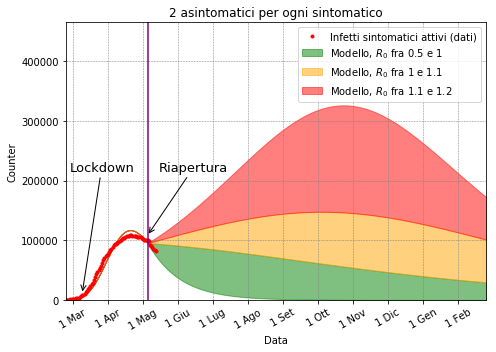

In [39]:
asympt=3

i_vec_future050=SIR_2_future(6*10**7,par_ideal[0]*1/14,1/14,0.5,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]
i_vec_future100=SIR_2_future(6*10**7,par_ideal[0]*1/14,1/14,1.0,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]
i_vec_future110=SIR_2_future(6*10**7,par_ideal[0]*1/14,1/14,1.1,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]
i_vec_future120=SIR_2_future(6*10**7,par_ideal[0]*1/14,1/14,1.20,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]

plt.figure(figsize=(7,5))
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti sintomatici attivi (dati)')
plt.fill_between(t, i_vec_future100/asympt,i_vec_future050/asympt,color='green',label='Modello, $R_0$ fra 0.5 e 1',alpha=0.5)
plt.fill_between(t, i_vec_future110/asympt,i_vec_future100/asympt,color='orange',label='Modello, $R_0$ fra 1 e 1.1',alpha=0.5)
plt.fill_between(t, i_vec_future120/asympt,i_vec_future110/asympt,color='red',label='Modello, $R_0$ fra 1.1 e 1.2',alpha=0.5)
#plt.plot(t, i_vec_future05/asympt, label='Modello, R$_0^{riapertura}$=0.5')
#plt.plot(t, i_vec_future10/asympt, label='Modello, R$_0^{riapertura}$=1')
#plt.plot(t, i_vec_future15/asympt, label='Modello, R$_0^{riapertura}$=1.1')
#plt.plot(t, i_vec_future20/asympt, label='Modello, R$_0^{riapertura}$=1.2')
#plt.fill_between(t, i_vec_future*(1+par_ideal[4]/100*2)/asympt,i_vec_future*(1-par_ideal[4]/100*2)/asympt, label='Infetti attivi (modello, 95% C.L.)',color='red',alpha=.2)
plt.plot(np.zeros(2)+70,[-1000,10**7],color='purple')
plt.xticks(np.arange(6,360,30),['1 Mar','1 Apr','1 Mag','1 Giu','1 Lug','1 Ago','1 Set','1 Ott','1 Nov','1 Dic','1 Gen','1 Feb'],rotation=30)
plt.xlim(0,360)
plt.ylim(100,ydata_inf.max()*4.3)
#plt.ylim(100,10**7)
#plt.yscale('log')
plt.annotate("Lockdown", xy=(14,ydata_inf.max()*0.1), xytext=(3,ydata_inf.max()*2), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.annotate("Riapertura", xy=(70,ydata_inf.max()), xytext=(80,ydata_inf.max()*2), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('2 asintomatici per ogni sintomatico')
plt.tight_layout()
plt.savefig('predizioni_future.png',dpi=300)
plt.show()

In [40]:
#export

ydata_inf_toexport=np.empty(len(i_vec))
ydata_inf_toexport[0:len(ydata_inf)]=ydata_inf
ydata_inf_toexport[len(ydata_inf):]=np.nan

t_date=pd.to_datetime(t,unit='D',origin=pd.Timestamp('2020-02-24'))

export_forecast = pd.DataFrame({'date':t_date,'t':t,'R0=0.5':i_vec_future050/asympt,'R0=1':i_vec_future100/asympt,'R0=1.1':i_vec_future110/asympt,'R0=1.2':i_vec_future120/asympt,'infetti_reali':ydata_inf_toexport})
export_forecast.to_csv('output/predizioni_future_export.csv',index=False)